In [20]:
import numpy as np
import pandas as pd
import spotpy
import matplotlib.pyplot as plt
import os


In [21]:
wd = "d:/Projects/Tools/DayCent-CUTE/tools/test01/dream_worker001"
os.chdir(wd)

In [22]:
class dc_cali_setup(object):

    def __init__(
        self, wd, observed_data, param_defs, parallel="seq", temp_dir=None
        ):
        """_summary_

        Args:
            swatmd (_type_): _description_
            observed_data (_type_): _description_
            param_defs (_type_): params will be used
            parallel (str, optional): _description_. Defaults to "seq".
        """
        self.wd = wd
        self.observed_data = observed_data
        # wd = parm.path_TxtInout
        os.chdir(wd)
        # print(os.getcwd())
        
        # self.upper_path = (os.path.split(os.getcwd())[0])


        # self.wd = wd
        # self.model = swatmd
        # self.observed_data = observed_data

        # parameters
        param_defs = self.read_dc_pars()
    
        # self.param_defs = param_defs
        self.params = [] # parameters used
        for i in range(len(param_defs)):
            self.params.append(
                    spotpy.parameter.Uniform(
                    name=param_defs.iloc[i, 0],
                    low=param_defs.iloc[i, 3],
                    high=param_defs.iloc[i, 4],
                    optguess=np.mean(
                        [float(param_defs.iloc[i, 3]), float(param_defs.iloc[i, 4])])))

        self.temp_dir = temp_dir
        self.parallel = parallel
        if self.parallel == "seq":
            pass
        if self.parallel == "mpi":
            from modules.mpi4py import MPI
            comm = MPI.COMM_WORLD
            self.mpi_size = comm.Get_size()
            self.mpi_rank = comm.Get_rank()

        # print(self.params)
    
    def read_dc_pars(self):
        df_fix = pd.read_csv('dc_fix.parms.csv')
        df_site = pd.read_csv('dc_site.parms.csv')
        df_pars = pd.concat([df_fix, df_site], axis=0)
        return df_pars


    def update_dc_parms_org(self, parameters):
        print(f"this iteration's parameters:")
        print(parameters)        

        # overwrite model.in file here with new parameter values
        # get swat parms
        dc_fix_parms = self.read_dc_pars()

        for i in range(len(dc_fix_parms)):
            dc_fix_parms.loc[i, 'val'] = parameters[i]


        with open('fix.100', "r") as f:
            updated = []
            for line in f.readlines():
                parnam = line.split()[1].strip().replace("'", "").replace(",", "_")
                if (parnam in dc_fix_parms.loc[:, "name"].tolist()):
                    new_val = dc_fix_parms.loc[dc_fix_parms['name'] == parnam, "val"].tolist()[0]
                    new_line = f"{new_val:<14.4f}{line.split()[1].strip()}\n"
                    updated.append(new_line)
                else:
                    updated.append(line)
                    
        with open('fix.100', "w") as wf:
            wf.writelines(updated)


    def update_dc_parms(self, parameters):
        print(f"this iteration's parameters:")
        print(parameters)        

        # overwrite model.in file here with new parameter values
        # get swat parms
        dc_parms = self.read_dc_pars()

        # for i in range(len(dc_parms)):
        #     dc_parms.loc[i, 'val'] = parameters[i]
        dc_parms['val'] = parameters
        with open('fix.100', "r") as f:
            updated = []
            for line in f.readlines():
                parnam = line.split()[1].strip().replace("'", "").replace(",", "_")
                if (parnam in dc_parms.loc[:, "name"].tolist()):
                    new_val = dc_parms.loc[dc_parms['name'] == parnam, "val"].tolist()[0]
                    new_line = f"{new_val:<14.4f}{line.split()[1].strip()}\n"
                    updated.append(new_line)
                else:
                    updated.append(line)

        with open('fix.100', "w") as wf:
            wf.writelines(updated)
            
            
        with open('sitepar.in', "r") as f:
            updated = []
            for line in f.readlines():
                parnam = line.split()[2].strip()
                if (parnam in dc_parms.loc[:, "name"].tolist()):
                    new_val = dc_parms.loc[dc_parms['name'] == parnam, "val"].tolist()[0]
                    new_line = f"{new_val:<11f}{line.split()[1].strip()} {line.split()[2].strip()}\n"
                    updated.append(new_line)
                else:
                    updated.append(line)

        with open('sitepar.in', "w") as wf:
            wf.writelines(updated)
                



    def parameters(self):
        return spotpy.parameter.generate(self.params)


    # Simulation function must not return values besides for which evaluation values/observed data are available
    def simulation(self, parameters):
        self.update_dc_parms(parameters)
        # model run
        with open("DayCentRUN.DAT", "r") as f:
            data = [x.strip().split() for x in f]
        print('')
        print('  Simulation start ...')
        for i in range(len(data)):
            if os.path.isfile(data[i][1]+".bin"):
                os.remove(data[i][1]+".bin")
            comline = 'DD17centEVI.exe -s {} -n {} -e {}'.format(data[i][1], data[i][1], data[i][3])
            run_model = subprocess.Popen(comline, stdout=subprocess.PIPE, cwd=".")
            run_model.wait()
            comline2 = 'DD17list100.exe {} {} {}'.format(data[i][1], data[i][1], 'outvars.txt')
            extract_model = subprocess.Popen(comline2, stdout=subprocess.PIPE, cwd=".")
            extract_model.wait()
        print('')
        print('  Simulation complete ...')
        print('')
        print('  extracting simulation outputs ...')
        # get all sims
        sim_df = pd.DataFrame()
        for i in range(len(data)):
            outf = data[i][1]+".lis"
            df = pd.read_csv( outf, sep=r'\s+', skiprows=1)
            df_sel = df.loc[(df['time']>=1971.08) & (df['time']<=1994.00)]
            df_sel.index = pd.date_range(start='1/1/1971', periods=len(df_sel), freq='M')
            dfa = df_sel.loc[:, ['somsc']].resample('A').mean()
            dfa.index = dfa.index.year
            dfa.rename(columns = {'somsc':'somsc_'+data[i][1][8:]}, inplace = True)
            sim_df = pd.concat([sim_df, dfa], axis=1)
            
        # get all obds
        obd_f = "soc_obd.csv"
        obd_df = pd.read_csv(obd_f).set_index('Year')  
        obd_df.replace(-999, np.nan, inplace=True)

        # filter only for calibration
        tot_df = pd.DataFrame()
        for col in sim_df.columns:
            tt =  pd.concat([sim_df.loc[:, col], obd_df.loc[:, col]], axis=1).dropna(axis=0)
            tt.columns = ['sim', 'obd']
            tt['name'] = col
            tot_df = pd.concat([tot_df, tt], axis=0)

        sim_list = tot_df.loc[:, 'sim'].tolist()
        print('  extracting simulation outputs ... passed')
        return sim_list

    def evaluation(self):
        return self.observed_data


    # if we want to minimize our function, we can select a negative objective function
    def objectivefunction(self, simulation, evaluation):

        print("simulation")
        print(len(simulation))
        print("evaluation")
        print(len(evaluation))

        objectivefunction = objectivefunctions.nashsutcliffe(
            evaluation, simulation
        )
        return objectivefunction

In [9]:
parallel = "seq"
df_fix = pd.read_csv('dc_fix.parms.csv')
df_site = pd.read_csv('dc_site.parms.csv')
param_defs = pd.concat([df_fix, df_site], axis=0)
obs_m = obs_masked()
# spot_setup = spot_setup(GausianLike)
spot_setup = dc_cali_setup(
    wd, obs_m, param_defs, parallel=parallel)

In [185]:
# Load the results gained with the dream sampler, stored in DREAM_hymod.csv
results = spotpy.analyser.load_csv_results("DREAM_dc_ppbias")
# Get fields with simulation data
fields = [word for word in results.dtype.names if word.startswith("sim")]


In [177]:
spot_setup.evaluation()

[3493.0,
 2805.0,
 3210.0,
 2370.0,
 2234.0,
 4230.0,
 3500.0,
 4250.0,
 3260.0,
 3673.0]

In [180]:
x_eval = ["ccc_ct_1971", "ccc_ct_1980", "ccc_ct_1992",
         "cb_ct_1980", "cb_ct_1992",
         "ccc_nt_1971", "ccc_nt_1980", "ccc_nt_1992",
         "cb_nt_1980", "cb_nt_1992"]

<IPython.core.display.Javascript object>


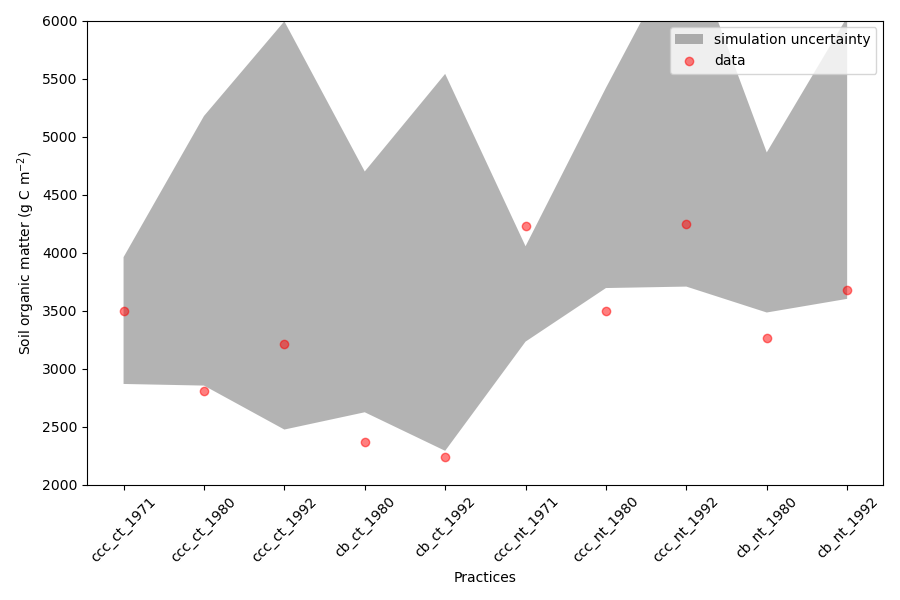

In [190]:
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(1, 1, 1)
q5, q25, q75, q95 = [], [], [], []
for field in fields:
    q5.append(
        np.percentile(results[field][-100:-1], 2.5)
    )  # ALl 100 runs after convergence
    q95.append(
        np.percentile(results[field][-100:-1], 97.5)
    )  # ALl 100 runs after convergence
# ax.plot(x_eval, q5, color="dimgrey", linestyle="solid")
# ax.plot(x_eval, q95, color="dimgrey", linestyle="solid")
ax.fill_between(
    np.arange(0, len(q5), 1),
    list(q5),
    list(q95),
    facecolor="dimgrey",
    zorder=0,
    alpha=0.5,
    linewidth=0,
    label="simulation uncertainty",
)

ax.scatter(x_eval, spot_setup.evaluation(), color="red", label="data", alpha=0.5)
ax.set_ylim(2000, 6000)
# ax.set_xlim(0, 729)
ax.set_ylabel("Soil organic matter (g C m$^{-2}$)")
ax.set_xlabel("Practices")
plt.xticks(rotation=45)
fig.tight_layout()
ax.legend()
fig.savefig("DREAM_simulation_uncertainty_Hymod.png", dpi=150)

In [66]:
wd = "d:/Projects/Tools/DayCent-CUTE/tools/test01/dream_worker001"
os.chdir(wd)


In [67]:
def obs_masked():
    # model run
    with open("DayCentRUN.DAT", "r") as f:
        data = [x.strip().split() for x in f]
    sim_df = pd.DataFrame()
    for i in range(len(data)):
        outf = data[i][1]+".lis"
        df = pd.read_csv( outf, sep=r'\s+', skiprows=1)
        df_sel = df.loc[(df['time']>=1971.08) & (df['time']<=1994.00)]
        df_sel.index = pd.date_range(start='1/1/1971', periods=len(df_sel), freq='M')
        dfa = df_sel.loc[:, ['somsc']].resample('A').mean()
        dfa.index = dfa.index.year
        dfa.rename(columns = {'somsc':'somsc_'+data[i][1][8:]}, inplace = True)
        sim_df = pd.concat([sim_df, dfa], axis=1)
        
    # get all obds
    obd_f = "soc_obd.csv"
    obd_df = pd.read_csv(obd_f).set_index('Year')  
    obd_df.replace(-999, np.nan, inplace=True)

    # filter only for calibration
    tot_df = pd.DataFrame()
    for col in sim_df.columns:
        tt =  pd.concat([sim_df.loc[:, col], obd_df.loc[:, col]], axis=1).dropna(axis=0)
        tt.columns = ['sim', 'obd']
        tt['name'] = col
        tot_df = pd.concat([tot_df, tt], axis=0)

    obd_list = tot_df.loc[:, 'obd'].tolist()
    return obd_list

In [107]:
# Select number of maximum repetitions
rep = 1000

# Select seven chains and set the Gelman-Rubin convergence limit
delta = 3
nChains = 61
convergence_limit = 1.2

# Other possible settings to modify the DREAM algorithm, for details see Vrugt (2016)
c = 0.1
nCr = 3
eps = 10e-6
runs_after_convergence = 100
acceptance_test_option = 6

In [60]:
r_hat = sampler.sample(
    rep,
    nChains,
    nCr,
    delta,
    c,
    eps,
    convergence_limit,
    runs_after_convergence,
    acceptance_test_option,
)

NameError: name 'sampler' is not defined

In [57]:
sampler = spotpy.algorithms.dream(
    spot_setup, dbname="DREAM_dc_nse_5000", dbformat="csv", parallel=parallel
)

In [61]:
spotpy.analyser.plot_gelman_rubin(results, r_hat, fig_name="DREAM_r_hat.png")

NameError: name 'r_hat' is not defined

In [112]:
int(max(results["chain"]))

61

In [108]:
def plot_parameter_trace2(ax, results, parameter):
    # THis function plots the parameter setting for each run
    for i in range(int(max(results["chain"]))):
        index = np.where(results["chain"] == i)
        ax.plot(results["par" + parameter["name"].replace("(", "").replace(")", "")][index], ".", markersize=2)
    ax.set_ylabel(parameter["name"])
    ax.set_ylim(parameter["minbound"], parameter["maxbound"])

In [145]:
def plot_posterior_parameter_histogram2(ax, results, parameter):
    # This functing is the last 100 runs
    ax.hist(
        results["par" + parameter["name"].replace("(", "").replace(")", "")][:100],
        bins=np.linspace(parameter["minbound"], parameter["maxbound"], 20),color = "gray", alpha=0.5, density=True
    )
    ax.hist(
        results["par" + parameter["name"].replace("(", "").replace(")", "")][:-100],
        bins=np.linspace(parameter["minbound"], parameter["maxbound"], 20), alpha=0.6, density=True
    )
    ax.set_ylabel("Density")
    ax.set_xlim(parameter["minbound"], parameter["maxbound"])

<IPython.core.display.Javascript object>


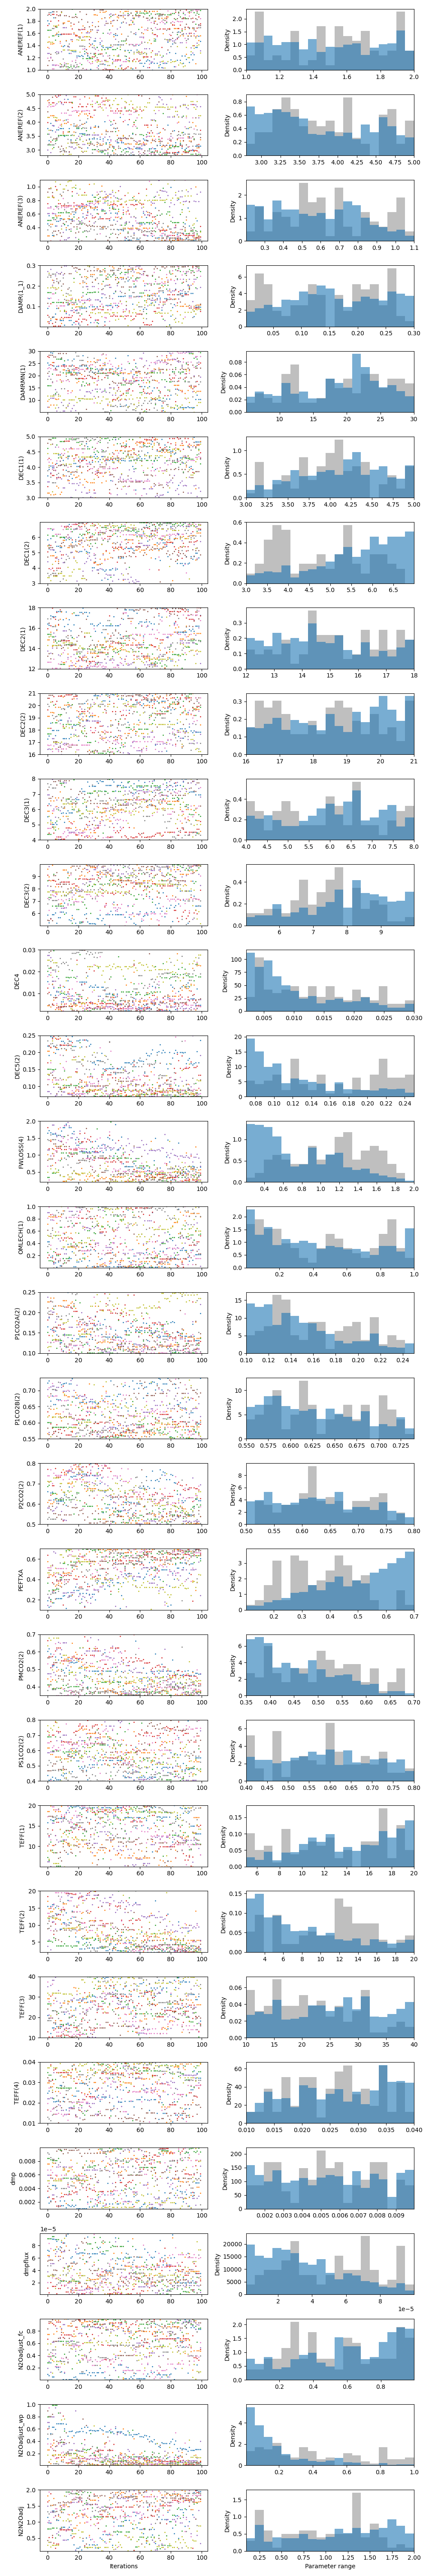

In [187]:
from spotpy.analyser import plot_parameter_trace, plot_posterior_parameter_histogram

# Example plot to show the parameter distribution ######
parameters = spotpy.parameter.get_parameters_array(spot_setup)

fig, ax = plt.subplots(nrows=30, ncols=2)
fig.set_figheight(60)
fig.set_figwidth(10)
# for par_id in range(5,11):
for par_id in range(len(parameters)):
    plot_parameter_trace2(ax[par_id][0], results, parameters[par_id])
    plot_posterior_parameter_histogram2(ax[par_id][1], results, parameters[par_id])

ax[-1][0].set_xlabel("Iterations")
ax[-1][1].set_xlabel("Parameter range")
fig.tight_layout()

plt.show()
fig.savefig("DREAM_parameter_uncertainty_Hymod.png", dpi=300)

In [76]:
import pkgutil

names = [
    name
    for importer, name, ispkg in pkgutil.iter_modules(__path__)
    if not ispkg and name != "base"
]

NameError: name '__path__' is not defined

In [ ]:
results[]

In [79]:
for i in range(int(max(results["chain"]))):
    index = np.where(results["chain"] == i)
#     results["par"
    ax.plot(results["par" + parameter["name"]][index], ".", markersize=2)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
# Load the results gained with the dream sampler, stored in DREAM_hymod.csv
results = spotpy.analyser.load_csv_results("DREAM_hymod")
# Get fields with simulation data
fields = [word for word in results.dtype.names if word.startswith("sim")]

# Example plot to show remaining parameter uncertainty #
fig = plt.figure(figsize=(9, 6))
ax = plt.subplot(1, 1, 1)
q5, q25, q75, q95 = [], [], [], []
for field in fields:
    q5.append(
        np.percentile(results[field][-100:-1], 2.5)
    )  # ALl 100 runs after convergence
    q95.append(
        np.percentile(results[field][-100:-1], 97.5)
    )  # ALl 100 runs after convergence
ax.plot(q5, color="dimgrey", linestyle="solid")
ax.plot(q95, color="dimgrey", linestyle="solid")
ax.fill_between(
    np.arange(0, len(q5), 1),
    list(q5),
    list(q95),
    facecolor="dimgrey",
    zorder=0,
    linewidth=0,
    label="simulation uncertainty",
)
ax.plot(spot_setup.evaluation(), color="red", markersize=2, label="data")
ax.set_ylim(-50, 450)
ax.set_xlim(0, 729)
ax.set_ylabel("Discharge [l s-1]")
ax.set_xlabel("Days")
ax.legend()
fig.savefig("DREAM_simulation_uncertainty_Hymod.png", dpi=150)
#########################################################

# Example plot to show the convergence #################
spotpy.analyser.plot_gelman_rubin(results, r_hat, fig_name="DREAM_r_hat.png")
########################################################

# Example plot to show the parameter distribution ######
parameters = spotpy.parameter.get_parameters_array(spot_setup)

fig, ax = plt.subplots(nrows=5, ncols=2)
fig.set_figheight(9)
fig.set_figwidth(9)
for par_id in range(len(parameters)):
    plot_parameter_trace(ax[par_id][0], results, parameters[par_id])
    plot_posterior_parameter_histogram(ax[par_id][1], results, parameters[par_id])

ax[-1][0].set_xlabel("Iterations")
ax[-1][1].set_xlabel("Parameter range")

plt.show()
fig.tight_layout()
fig.savefig("DREAM_parameter_uncertainty_Hymod.png", dpi=300)

<IPython.core.display.Javascript object>


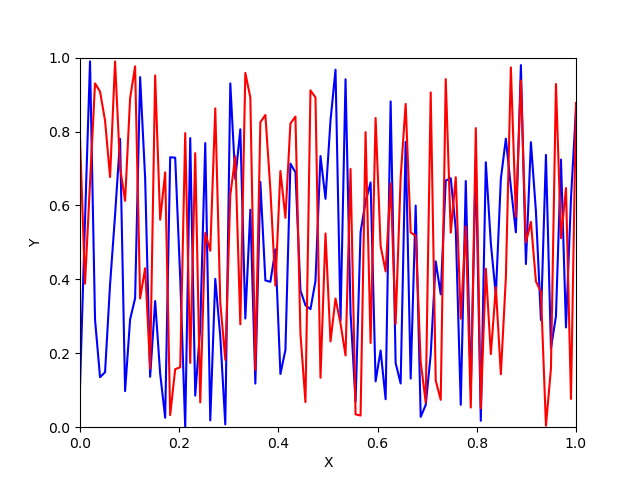

In [19]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, colors=['b']):
    x = np.linspace(0,1,100)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            y = np.random.random(size=(100,1))
            line.set_ydata(y)
    else:
        for color in colors:
            y = np.random.random(size=(100,1))
            ax.plot(x, y, color)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
for f in range(5):
    pltsin(ax, ['b', 'r'])
    time.sleep(1)

In [93]:
df =  pd.read_csv('SCEUA_hymod.csv')

In [94]:
df

,like1,parANEREF(1),parANEREF(2),parANEREF(3),parDAMR(1_1),parDAMRMN(1),parDEC1(1),parDEC1(2),parDEC2(1),parDEC2(2),...,simulation_1,simulation_2,simulation_3,simulation_4,simulation_5,simulation_6,simulation_7,simulation_8,simulation_9,chain
0,809.56480,1.110329,4.777857,0.324945,0.122654,20.402325,3.201195,6.089427,16.125320,16.335028,...,3748.4387,3751.4558,3456.9443,3484.8665,3653.2830,4396.9980,4794.7285,4030.5735,4440.3560,0.0
1,650.65570,1.089006,4.401569,0.793423,0.071537,18.621773,4.521845,4.396507,13.733218,18.723680,...,2689.8245,2537.2620,2626.4570,2483.3914,3013.6377,3103.8142,3169.7476,3062.9167,3129.9321,0.0
2,849.29440,1.248261,4.666397,0.541823,0.013443,29.374485,3.920602,3.423064,12.833248,18.702158,...,2254.8610,1716.7523,2164.1987,1695.4463,2969.2760,3127.1067,3042.2122,3218.0706,3203.6353,0.0
3,578.45026,1.593529,4.649000,0.204908,0.218308,8.897134,4.145099,4.903763,17.396510,18.437712,...,2687.5310,2319.1018,2411.6350,2102.5503,3165.3567,3501.2974,3464.9207,3213.7273,3224.1800,0.0
4,712.50030,1.334016,4.496475,0.636677,0.036796,21.619976,4.132737,5.991064,12.678187,16.965008,...,2501.9565,2294.7178,2376.8572,2136.1538,3003.1028,3086.2593,3149.4768,2994.4973,2987.4937,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,397.48868,1.525077,4.064873,0.490025,0.169784,18.471405,4.269762,5.333550,14.877074,18.545055,...,3088.8726,2787.7498,2734.4680,2482.9998,3523.1045,4023.5667,4189.2544,3634.2150,3799.8564,57.0
2192,387.43230,1.561232,4.154587,0.530876,0.196796,17.724688,4.195492,4.918085,15.407522,18.087715,...,3069.3027,2804.1443,2762.8748,2522.9458,3554.4307,3998.1465,4104.7275,3633.7795,3729.7695,58.0
2193,401.72034,1.440238,4.283863,0.716492,0.166669,17.887846,4.231484,4.738984,15.761269,17.985992,...,2881.9956,2507.2732,2546.3628,2212.6362,3525.4246,3924.9114,3995.1448,3555.2712,3616.2488,59.0
2194,386.55435,1.649869,4.027750,0.540281,0.191912,18.497670,4.146655,5.097560,15.334022,18.680130,...,3088.8157,2784.5134,2731.3070,2457.3555,3608.5288,4074.2737,4220.9930,3673.9370,3793.5886,60.0


In [95]:
t = df.loc[df['chain']==1]
t.sort_values(by=['like1'])

,like1,parANEREF(1),parANEREF(2),parANEREF(3),parDAMR(1_1),parDAMRMN(1),parDEC1(1),parDEC1(2),parDEC2(1),parDEC2(2),...,simulation_1,simulation_2,simulation_3,simulation_4,simulation_5,simulation_6,simulation_7,simulation_8,simulation_9,chain
1830,415.94855,1.505038,4.897726,0.612160,0.058645,18.012142,4.489110,6.027522,16.197548,18.306774,...,2945.9346,2531.3800,2530.4220,2206.4536,3433.3723,3959.2705,4174.8310,3537.6394,3752.6690,1.0
1891,419.40924,1.563015,3.985136,0.531174,0.152344,17.324942,3.977645,5.151339,15.159639,18.325148,...,2928.3367,2565.1997,2572.2350,2276.4255,3390.1420,3869.7178,3988.0180,3484.2473,3628.6140,1.0
1769,427.47745,1.367266,3.437422,0.579419,0.203002,13.620382,4.206072,4.812884,15.584257,17.813776,...,2868.7112,2483.5742,2509.5488,2180.4756,3434.1174,3915.8677,4020.9065,3522.8354,3631.8190,1.0
2135,429.08383,1.488430,4.105245,0.494007,0.156690,15.870496,4.214790,5.211696,16.277300,18.235415,...,3221.7498,2983.4233,2879.7737,2684.9310,3602.0457,4109.9690,4293.3315,3725.5276,3906.7578,1.0
2074,433.31235,1.471480,4.562360,0.519344,0.135460,13.504199,3.970226,5.253654,14.686359,17.893396,...,3048.9285,2796.0554,2809.8103,2617.1480,3388.2808,3865.6936,3931.6477,3597.8696,3685.4539,1.0
2013,436.83410,1.651300,4.128408,0.610052,0.187070,16.415102,3.938774,5.378773,15.277765,18.343310,...,3065.6306,2733.5880,2722.2660,2439.8914,3366.8500,3973.9850,4232.2354,3657.8880,3881.6282,1.0
1220,438.34406,1.476406,4.164434,0.582713,0.126513,13.408653,4.109925,5.687297,15.406109,18.055178,...,2931.2730,2641.0240,2644.6040,2424.9995,3295.7717,3777.4038,3905.9020,3435.4565,3602.2358,1.0
1708,453.76130,1.530193,3.949281,0.508179,0.179074,10.876050,4.132678,4.602246,15.935688,18.795475,...,2813.3337,2447.0435,2472.5273,2156.7537,3333.6326,3753.9563,3867.7690,3390.0042,3498.3918,1.0
1281,472.54790,1.775347,4.355449,0.671575,0.208138,15.925571,3.931846,5.917534,15.780952,18.300362,...,2874.0552,2574.2876,2684.0234,2386.7580,3237.3770,3760.2520,3988.1401,3617.2214,3818.9072,1.0
1952,480.10324,1.294990,3.536199,0.617860,0.191087,14.539206,3.659443,5.512989,14.649446,18.384030,...,2751.5398,2345.8887,2376.8435,2037.0104,3291.1167,3743.7450,3944.4650,3351.8580,3535.8867,1.0


<IPython.core.display.Javascript object>


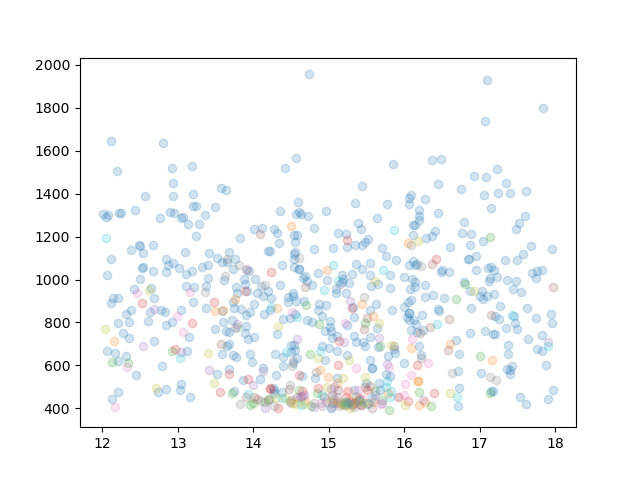

In [99]:
fig, ax = plt.subplots()
for i in range(10):
    t = df.loc[df['chain']==i]
    ax.scatter(t['parDEC2(1)'], t['like1'], alpha=0.2)

fig.show()

<IPython.core.display.Javascript object>


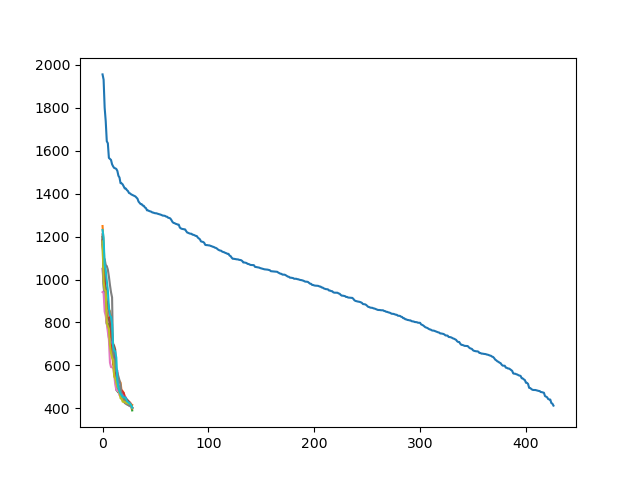

In [188]:
fig, ax = plt.subplots()
for i in range(10):
    t = df.loc[df['chain']==i]
    t = t.sort_values(by=['like1'], ascending=False)
    t = t.reset_index()
    ax.plot(t.index, t['like1'])
plt.show()

In [103]:
t.columns

Index(['index', 'like1', 'parANEREF(1)', 'parANEREF(2)', 'parANEREF(3)',
       'parDAMR(1_1)', 'parDAMRMN(1)', 'parDEC1(1)', 'parDEC1(2)',
       'parDEC2(1)', 'parDEC2(2)', 'parDEC3(1)', 'parDEC3(2)', 'parDEC4',
       'parDEC5(2)', 'parFWLOSS(4)', 'parOMLECH(1)', 'parP1CO2A(2)',
       'parP1CO2B(2)', 'parP2CO2(2)', 'parPEFTXA', 'parPMCO2(2)',
       'parPS1CO2(2)', 'parTEFF(1)', 'parTEFF(2)', 'parTEFF(3)', 'parTEFF(4)',
       'pardmp', 'pardmpflux', 'parN2Oadjust_fc', 'parN2Oadjust_wp',
       'parN2N2Oadj', 'simulation_0', 'simulation_1', 'simulation_2',
       'simulation_3', 'simulation_4', 'simulation_5', 'simulation_6',
       'simulation_7', 'simulation_8', 'simulation_9', 'chain'],
      dtype='object')

In [105]:
bestindex,bestobjf = spotpy.analyser.get_minlikeindex(results)

Run number 2185 has the lowest objectivefunction with: 376.7281


<IPython.core.display.Javascript object>


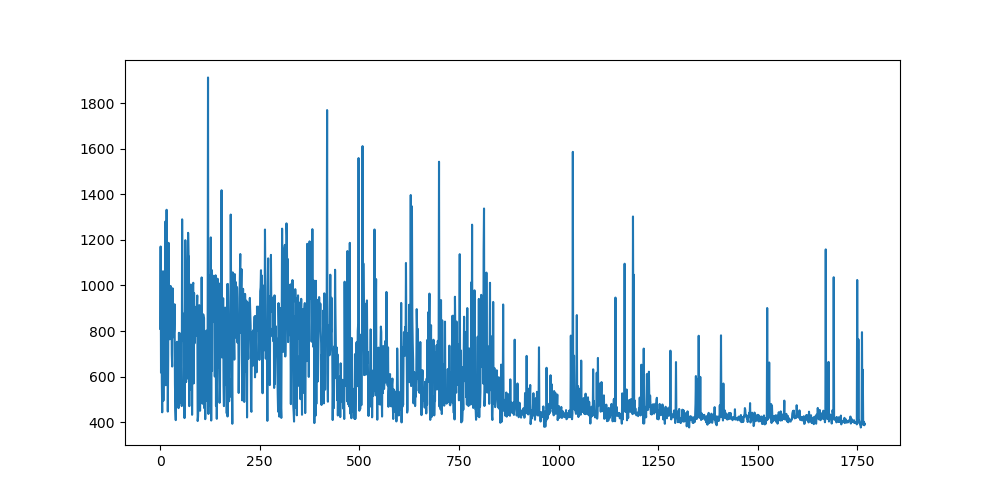

In [170]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results['like1'])
plt.show()

In [104]:
fig= plt.figure(1,figsize=(9,5))
plt.plot(results['like1'])
plt.show()
plt.ylabel('RMSE')
plt.xlabel('Iteration')
fig.savefig('SCEUA_objectivefunctiontrace1.png',dpi=300)

In [55]:
t.sort_values(by=['like1'])

,like1,parANEREF(1),parANEREF(2),parANEREF(3),parDAMR(1_1),parDAMRMN(1),parDEC1(1),parDEC1(2),parDEC2(1),parDEC2(2),...,simulation_1,simulation_2,simulation_3,simulation_4,simulation_5,simulation_6,simulation_7,simulation_8,simulation_9,chain
69,4.139016,1.528240,3.984296,0.308866,0.171604,19.770042,4.381880,5.388891,13.217791,16.712864,...,3201.4194,3102.7703,3128.6807,3072.6750,3223.8103,3715.5452,4063.0361,3726.6335,4149.6200,9.0
99,17.773207,1.994753,4.339117,0.665195,0.019718,17.542177,3.092350,6.100288,13.217791,20.474821,...,2380.8400,2106.1858,2672.7124,2446.8748,2846.7095,2756.3950,2618.2866,3318.2922,3419.3848,9.0
239,18.763004,1.335283,4.720447,1.095420,0.093751,11.602406,4.034513,6.818492,13.187012,19.327223,...,2340.3804,1842.9691,1966.9326,1566.8534,3211.1450,3504.2947,3545.7842,3111.2617,3143.2430,9.0
589,21.412390,1.767127,3.911985,0.394752,0.090929,18.219069,4.584905,3.964113,12.363717,16.276610,...,2250.2913,1867.9637,2506.6926,2163.2913,2829.7012,2787.6062,2600.9167,3213.1560,3201.6150,9.0
39,21.865936,1.889655,4.120920,0.809029,0.092982,9.868442,3.153567,6.225641,12.534775,19.178620,...,2189.2780,1763.4720,2268.9421,1904.6835,2922.9866,2927.7530,2838.4030,3210.4270,3288.2769,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,235.279130,1.996370,2.800776,1.092945,0.076285,14.360944,3.487160,6.498592,16.855980,19.181675,...,-4528.7050,-5264.8170,-3729.3777,-3958.6306,-2679.6882,-5120.8022,-6473.1353,-4587.2305,-5615.4000,9.0
4889,235.955000,1.998402,2.804519,1.093373,0.059080,17.986319,3.548013,5.378367,15.276549,19.481646,...,-4483.1846,-5186.6030,-3810.0420,-4104.1343,-2669.4540,-5101.2627,-6438.1760,-4661.0728,-5744.0635,9.0
4439,236.469470,1.999573,2.800485,1.092670,0.076285,9.347303,3.487160,6.111852,16.855980,19.141740,...,-4543.5967,-5261.4585,-3801.3354,-4023.1355,-2742.5945,-5146.8680,-6477.4897,-4653.1910,-5654.0054,9.0
4969,236.643260,1.999196,2.807666,1.093598,0.122008,18.823100,3.499329,5.005175,13.665738,19.305712,...,-4492.2417,-5257.9710,-3860.0227,-4230.6807,-2584.9966,-5072.4480,-6492.6580,-4665.9770,-5821.5370,9.0


In [ ]:
def plot_gelman_rubin(results, r_hat_values, fig_name="gelman_rub.png"):
    """Input:  List of R_hat values of chains (see Gelman & Rubin 1992)
    Output: Plot as seen for e.g. in (Sadegh and Vrugt 2014)"""
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(9, 6))
    ax1 = plt.subplot(2, 1, 1)
    for i in range(int(max(results["chain"])) + 1):
        index = np.where(results["chain"] == i)
        ax1.plot(results["like1"][index], label="Chain " + str(i + 1))
    ax1.set_ylabel("Likelihood value")
    ax1.legend()

    ax2 = plt.subplot(2, 1, 2)
    r_hat = np.array(r_hat_values)
    ax2.plot([1.2] * len(r_hat), "k--")
    for i in range(len(r_hat[0])):
        ax2.plot(r_hat[:, i], label="x" + str(i + 1))
    ax2.set_yscale("log", nonpositive="clip")
    ax2.set_ylabel("R$^d$ - convergence diagnostic")
    ax2.set_xlabel("Number of chainruns")
    ax2.legend()
    fig.savefig(fig_name, dpi=150)